<a href="https://colab.research.google.com/github/grndnl/w266_final_project/blob/main/Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bert Fine tunned with ABC Dataset

In [ ]:
!pip install -q sentencepiece
!pip install -q transformers
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from tqdm import tqdm
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from transformers import BertTokenizer, TFBertModel, DataCollatorForLanguageModeling

     |████████████████████████████████| 1.3 MB 3.5 MB/s 
     |████████████████████████████████| 5.3 MB 4.9 MB/s 
     |████████████████████████████████| 163 kB 70.3 MB/s 
     |████████████████████████████████| 7.6 MB 49.3 MB/s 


### Pre-process data for task

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_path = "/content/drive/My Drive/w266/data_02.csv"
data = pd.read_csv(data_path)

In [ ]:
type(data)

pandas.core.frame.DataFrame

In [ ]:
data = data.dropna(subset=["assembly_name", "part_names"])
data = data.drop(columns=["assembly_id"])
data

,assembly_name,assembly_description,part_names
0,Lava Lamp 2,NaN,"['Blob3', 'Blob2', 'Blob1', 'Glass', 'Cap']"
1,Sample - Headphones,NaN,"['Pivot hinge', 'Headphone hinge', 'Telescope ..."
4,Coffee Mug,NaN,"['Mug', 'Lid']"
5,Dave's Handsome Mug,NaN,"['Lid', 'Seal', 'Vessel']"
9,Mechanical Pencil,NaN,"['Eraser', 'Pencil Lead', 'Rubber Grip', 'Grip..."
...,...,...,...
456785,Mr Klapperich's copy to test drawing creation,NaN,['<4-40 Screw>-<CirPattern1>']
456788,2017-2018 9889,NaN,"['WHEEL-HUB-IN-L', 'WHEEL-HUB-OUT-R', 'WHEEL-H..."
456789,Copy of Tutorial 3 - Make Your First Assembly ...,NaN,"['Finished Arm', 'Plunger', 'Oring', 'Cylinder']"
456792,Table,NaN,"['Leg 350x850', 'Pin', 'Leg 310x850']"


In [ ]:
def process_string(string):
    string = string.lower()
    string = string.replace('_', '')
    string = string.replace('-', '')
    string = string.replace('[', '')
    string = string.replace(']', '')
    string = string.replace('(', '')
    string = string.replace(')', '')
    string = string.replace("'", '')
    string= string.split(',')
    return string

def process_string2(string):
    string = string.lower()
    string = string.replace('_', '')
    string = string.replace('-', '')
    string = string.replace('[', '')
    string = string.replace(']', '')
    string = string.replace('(', '')
    string = string.replace(')', '')
    string = string.replace("'", '')
    string= string.split(" ")
    return string


In [ ]:
strings = []
labels = []
for index, row in tqdm(data.iterrows(), total=len(data)):
  string_split = process_string(str(row['part_names']))
  if len(string_split) > 0:
    if pd.isna(row['assembly_description'])==False:
        phrase = f"The assembly description is '{row['assembly_description']}' has the following parts: "
        for part_name in string_split:
            phrase += f"{part_name}, "
        #print(phrase)
    else:
        phrase = f"there are the following parts: "
        for part_name in string_split:
            phrase += f"{part_name}, "
    strings.append(phrase)
    labels.append(process_string2(row['assembly_name'])[0])
    


100%|██████████| 88886/88886 [00:06<00:00, 14516.42it/s]


In [ ]:
labels[:10]

['lava',
 'sample',
 'coffee',
 'daves',
 'mechanical',
 'os',
 'torch',
 'bottle',
 'concept',
 'mounting']

In [ ]:
type(labels)

list

In [ ]:
from collections import Counter
  
def unique(list1):
  
    # Print directly by using * symbol
    return(len(Counter(list1)))

unique(labels)/len(labels)

0.4081520149404856

In [ ]:
print(unique(labels))
print(len(strings))

36279
88886


In [ ]:
my_dict = {}
i=0
for item in labels:
    if item not in my_dict:
        my_dict[item] = i
        i+=1

print(my_dict)

{'lava': 0, 'sample': 1, 'coffee': 2, 'daves': 3, 'mechanical': 4, 'os': 5, 'torch': 6, 'bottle': 7, 'concept': 8, 'mounting': 9, 'home': 10, 'autoturret.xt': 11, 'robot': 12, 'main': 13, 'case': 14, 'weldment2': 15, 'compass': 16, 'veco': 17, 'automated': 18, 'mec000992er.sldprt': 19, 'ibeam.stp': 20, '3d': 21, 'boat': 22, 'cylinder': 23, 'clamp': 24, 'scanner': 25, 'assembled': 26, 'sumitomo': 27, 'hard': 28, 'halloweenmachine': 29, 'motw': 30, 'hexapod': 31, 'composite': 32, '18700': 33, 'casting': 34, 'custom': 35, '26650': 36, 'independent': 37, 'resync': 38, 'bellroller': 39, 'tutorial': 40, 'mechanism': 41, 'onshapeit': 42, 'box': 43, 'quadro': 44, 'dlogger': 45, 'level': 46, 'knob,': 47, 'camera': 48, 'am1': 49, '6axis': 50, 'three': 51, 'tablet': 52, '25100w.stp': 53, 'gumdrop': 54, 'cc': 55, 'tiny': 56, 'crankpiston': 57, 'fixtures': 58, 'sawsall': 59, 'thermostat': 60, 'fasteners': 61, 'logo': 62, 'lightweight': 63, 'motorcycle': 64, 'light': 65, 'classic': 66, '37': 67, 'fl

In [ ]:
strings[100:180]

['there are the following parts: maintenance bleeder hose,  bleeder screw,  guide,  bolt,  pad,  seal,  piston,  outer caliper,  inner caliper, ',
 'there are the following parts: plug,  screw mount,  quick change base,  oring,  pull stud,  custom clamp,  custom clamp,  pin,  subplate, ',
 'there are the following parts: ring,  venturi05,  venturi04,  venturi03,  venturi02,  venturi01, ',
 'there are the following parts: motor mount, ',
 'there are the following parts: m8 socket head cap screw,  m8 socket head cap screw,  m8 socket head cap screw,  m8 socket head cap screw,  m5 socket head cap screw,  m5 socket head cap screw,  m5 socket head cap screw,  m5 socket head cap screw,  m5 socket head cap screw,  m5 socket head cap screw,  m5 socket head cap screw,  m5 socket head cap screw,  screws for measurement unit,  screws for measurement unit,  screws for measurement unit,  screws for measurement unit,  m5 socket head cap screw,  m5 socket head cap screw,  m5 socket head cap screw,  m

In [ ]:
#from collections import OrderedDict
#train_label_index=[]
#unique_labels=list(OrderedDict.fromkeys(labels).keys())


#for i in range(0,len(unique_labels)):
  #train_label_index.append(i)


In [ ]:
train_strings, test_strings, train_labels, test_labels = train_test_split(strings,labels, test_size=0.2)
print(f"Length of train: {len(train_strings)}")
print(f"Length of test: {len(test_strings)}")
print(f"Length of train: {len(train_labels)}")
print(f"Length of train: {len(test_labels)}")

Length of train: 71108
Length of test: 17778
Length of train: 71108
Length of train: 17778


#Creating Bert Model

In [ ]:
max_length = 128
model_checkpoint = 'bert-base-uncased'
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert_model = TFBertModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
from collections import OrderedDict
train_label_index=[]
test_label_index=[]
for item in train_labels:
  train_label_index.append(my_dict[item])

for i in test_labels:
  test_label_index.append(my_dict[item])    


In [ ]:
len(list(OrderedDict.fromkeys(train_labels).keys()))

30375

In [ ]:
len(train_label_index)

71108

In [ ]:
len(train_labels)

71108

In [ ]:
# BERT Tokenization of training and test data

num_train_examples = 20000      # set number of train examples - 1500 for realtime demo
num_test_examples = 5000        # set number of test examples - 500 for realtime demo

max_length = 128                 # set max_length

all_train_examples = train_strings
all_test_examples = test_strings

y_train =  tf.convert_to_tensor(train_label_index[:num_train_examples])
              
x_train = bert_tokenizer(all_train_examples[:num_train_examples],
              max_length=max_length,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')

              

y_test =  tf.convert_to_tensor(test_label_index[:num_test_examples])
x_test = bert_tokenizer(all_test_examples[:num_test_examples],
              max_length=max_length,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')


In [ ]:
def create_bert_classification_model(bert_model,
                                     train_layers=-1,
                                     hidden_size = 200, 
                                     dropout=0.3,
                                     learning_rate=0.0001):
    """
    Build a simple classification model with BERT. Use the Pooled Output for classification purposes
    """
    
    bert_model.trainable = True
    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}      

    bert_out = bert_model(bert_inputs)

    pooled_token = bert_out[1]
    #cls_token = bert_out[0][:, 0, :]

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(pooled_token)


    hidden = tf.keras.layers.Dropout(dropout)(hidden)  


    classification = tf.keras.layers.Dense(36279, activation='softmax',name='classification_layer')(hidden)
    
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                                 metrics='accuracy')

    
    return classification_model

In [ ]:
bert_classification_model = create_bert_classification_model(bert_model)

In [ ]:
bert_classification_model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                           

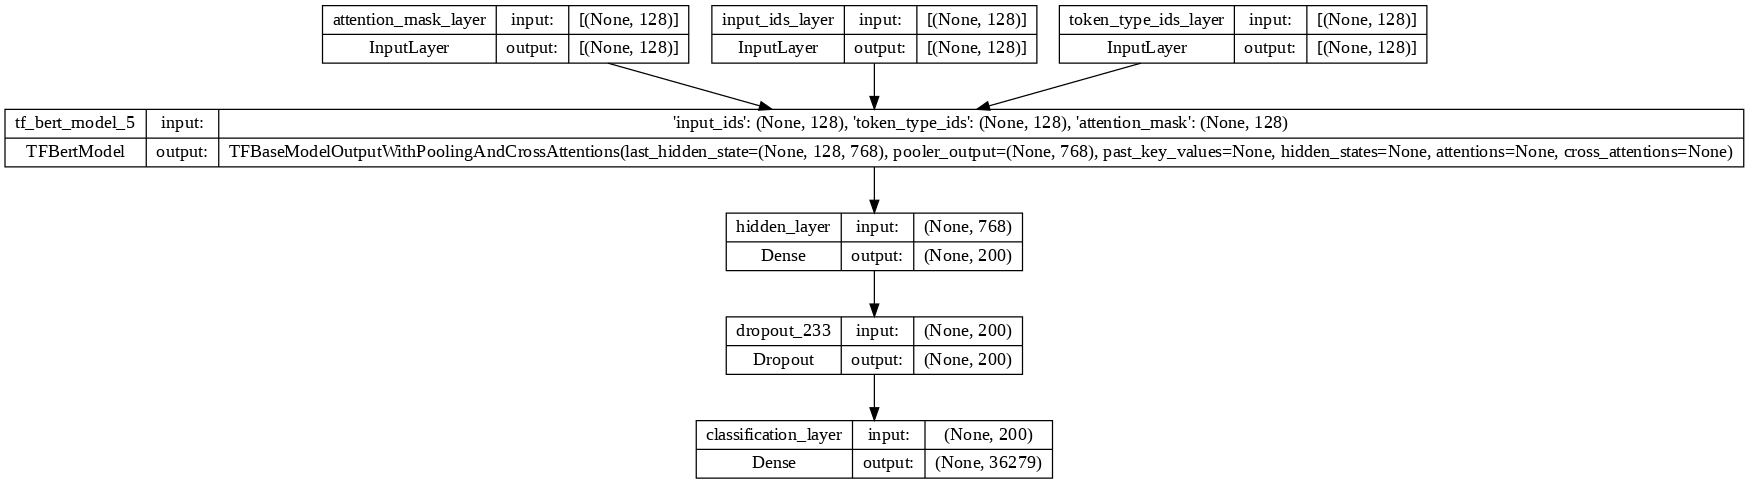

In [ ]:
keras.utils.plot_model(bert_classification_model, show_shapes=True, dpi=90)

In [ ]:
bert_classification_model_history = bert_classification_model.fit(
    [x_train.input_ids, x_train.token_type_ids, x_train.attention_mask],
    y_train,
    validation_data=([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask], y_test),
    batch_size=32,
    epochs=10
)  

Epoch 1/10
625/625 [==============================] - 545s 857ms/step - loss: 9.4337 - accuracy: 0.0663 - val_loss: 11.2368 - val_accuracy: 0.0000e+00
Epoch 2/10
625/625 [==============================] - 533s 852ms/step - loss: 8.6871 - accuracy: 0.0680 - val_loss: 12.0243 - val_accuracy: 0.0000e+00
Epoch 3/10
625/625 [==============================] - 532s 852ms/step - loss: 8.5274 - accuracy: 0.0680 - val_loss: 12.6053 - val_accuracy: 0.0000e+00
Epoch 4/10
625/625 [==============================] - 533s 852ms/step - loss: 8.4516 - accuracy: 0.0680 - val_loss: 13.1108 - val_accuracy: 0.0000e+00
Epoch 5/10
625/625 [==============================] - 533s 852ms/step - loss: 8.4114 - accuracy: 0.0680 - val_loss: 13.2732 - val_accuracy: 0.0000e+00
Epoch 6/10
625/625 [==============================] - 532s 852ms/step - loss: 8.3835 - accuracy: 0.0680 - val_loss: 13.7410 - val_accuracy: 0.0000e+00
Epoch 7/10
625/625 [==============================] - 532s 852ms/step - loss: 8.3705 - accurac